In [397]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [452]:
import torch

def generate_time_series_features_pytorch(n_samples, n_features, n_steps=100, noise_level=0.01):
    """
    Generates a synthetic time series dataset with n_samples and n_features using PyTorch.
    
    Parameters:
    - n_samples: int, the number of samples to generate.
    - n_features: int, the number of features (time series) to generate for each sample.
    - n_steps: int, the number of time steps for each feature.
    - noise_level: float, the level of noise to add to the time series.
    
    Returns:
    - A tuple of PyTorch tensors: (features, target) where
      features is of shape (n_samples, n_steps, n_features) representing the generated time series data,
      and target is a tensor for the target variable.
    """
    # Time axis for the sine wave
    time = torch.linspace(0, 2 * torch.pi, n_steps)
    
    # Generate sine waves for each feature and sample
    features = torch.stack([torch.stack([torch.sin(time + 4*torch.rand(1) * 2 * torch.pi) for _ in range(n_samples)]).T for _ in range(n_features)], dim=2).permute(1, 0, 2)    
    # Add noise
    features += torch.randn(features.shape) * noise_level
    
    # Example target calculation (modify according to your needs)
    # Calcul de la cible en combinant les caractéristiques
    # Exemple : une combinaison linéaire des caractéristiques avec des poids arbitraires
    weights = torch.tensor([0.4, 0.2, 0.4])  # Poids pour 3 caractéristiques, ajustez selon le nombre de caractéristiques
    if n_features >= 3:
        target = features[:, 5, 0] * weights[0] * features[:, 10, 1] * weights[1] + features[:, -10, 2] + weights[2]
        #la target sera simplement la valeur finale du vecteur target
    else:
        # Si moins de 3 caractéristiques, utilisez une logique différente ou ajustez les poids
        target = features[:, :, 0]  # Fallback simple si moins de 3 caractéristiques

    return features, target

In [399]:
#print if cuda is available
print(torch.cuda.is_available())

True


the target is 1.0057439804077148
recalculate the target using the weights and the features
tensor(-1.0167) tensor(-0.1469) tensor(0.5938)
the target is 1.0057439804077148


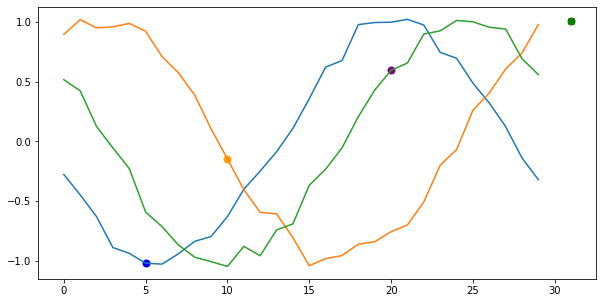

In [504]:
features, target = generate_time_series_features_pytorch(n_features=3, n_steps=30, noise_level=0.05, n_samples=600)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in range(features.shape[2]):
    ax.plot(features[0, :, i], label=f'Feature {i+1}')
    #display the target
ax.scatter(31, target[0], label='Target', linewidth=2, color='red', marker='x')
    
print(f'the target is {target[0]}')
print('recalculate the target using the weights and the features')
print(features[0, 5, 0], features[0, 10, 1], features[0, -10, 2])
weights = torch.tensor([0.4, 0.2, 0.4])  # Poids pour 3 caractéristiques, ajustez selon le nombre de caractéristiques
recalculated_target = features[0, 5, 0] * weights[0] * features[0, 10, 1] * weights[1] + features[0, -10, 2] + weights[2]
print(f'the target is {recalculated_target}')
ax.scatter(31, recalculated_target, label='Recalculated Target', linewidth=2, color='green', marker='o')
#plot the key features
ax.scatter(5, features[0, 5, 0], label='Feature 1', linewidth=2, color='blue', marker='o')
ax.scatter(10, features[0, 10, 1], label='Feature 2', linewidth=2, color='orange', marker='o')
ax.scatter(20, features[0, -10, 2], label='Feature 3', linewidth=2, color='purple', marker='o')

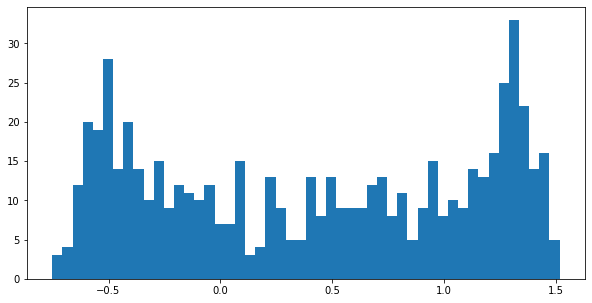

In [466]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
c = ax.hist(target, bins=50)

In [467]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Supposons que `features` est votre ensemble de données [samples, time_steps, features]
# Calculer les moyennes et écarts-types pour chaque caractéristique
scaler = StandardScaler()

# Redimensionner les données pour la normalisation: [samples*time_steps, features]
num_samples, num_time_steps, num_features = features.shape
features_reshaped = features.reshape(-1, num_features)

scaler.fit(features_reshaped)  # Fit sur l'ensemble d'entraînement

# Appliquer la normalisation
features_normalized = scaler.transform(features_reshaped)

# Remettre les données dans leur forme originale
features_normalized = features_normalized.reshape(num_samples, num_time_steps, num_features)

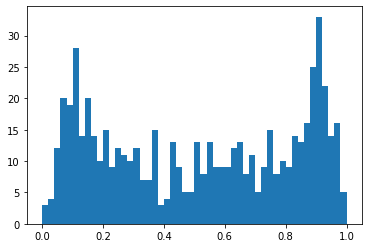

In [468]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Supposons que `target` est votre ensemble de cibles [samples,]
# Redimensionner `target` en une matrice 2D [samples, 1] pour le MinMaxScaler
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_2d = target.reshape(-1, 1)

# Adapter le scaler à la cible redimensionnée
target_scaler.fit(target_2d)

# Appliquer la normalisation à la cible redimensionnée
target_normalized = target_scaler.transform(target_2d)
c = plt.hist(target_normalized, bins=50)

In [469]:
features_normalized.shape

(600, 30, 3)

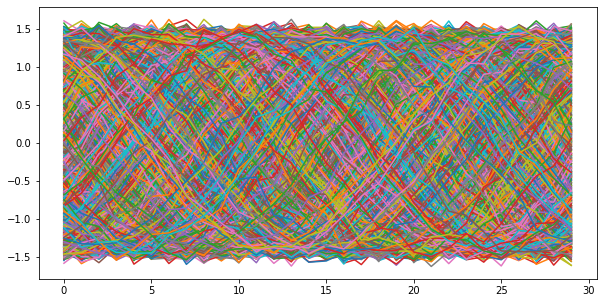

In [470]:
#plot normalized features features_normalized 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in range(features_normalized.shape[0]):
    ax.plot(features_normalized[i, :, :], label=f'Feature {i+1}')

In [471]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # Ajouter l'argument num_layers pour spécifier le nombre de couches LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialiser l'état caché et l'état de la cellule
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # x de forme: [batch_size, seq_len, input_dim]
        lstm_out, _ = self.lstm(x, (h0, c0))
        # Sélectionner la dernière sortie temporelle pour chaque séquence
        last_time_step = lstm_out[:, -1, :]
        y_pred = self.linear(last_time_step)
        return y_pred

# Exemple d'utilisation avec 2 couches LSTM
# input_dim = 3, hidden_dim = 50, output_dim = 1, num_layers = 2
model = LSTMModel(input_dim=3, hidden_dim=30, output_dim=1, num_layers=10)

In [476]:
def make_model(input_dim, hidden_dim, output_dim, num_layers, lr=0.01):
    model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    return model, criterion, optimizer, device

def split_data(features_normalized, target_normalized, device, test_size=0.2):
    features_train, features_test, target_train, target_test = train_test_split(
    features_normalized, target_normalized, test_size=test_size, random_state=42)

    # Convertir en tenseurs PyTorch et envoyer au dispositif approprié
    features_train_tensor = torch.tensor(features_train, dtype=torch.float).to(device)
    target_train_tensor = torch.tensor(target_train, dtype=torch.float).to(device)
    features_test_tensor = torch.tensor(features_test, dtype=torch.float).to(device)
    target_test_tensor = torch.tensor(target_test, dtype=torch.float).to(device)
    return features_train_tensor, target_train_tensor, features_test_tensor, target_test_tensor

def train_model(model, optimizer, criterion, features_train_tensor, target_train_tensor, features_test_tensor, target_test_tensor, n_epochs=300, patience=100):
    best_loss = np.inf
    epochs_no_improve = 0
    loss_save = []
    r2_save = {}
    best_r2 = float('-inf')
    epochs_no_improve_r2 = 0

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(features_train_tensor)
        loss = criterion(y_pred, target_train_tensor)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            y_val_pred = model(features_test_tensor)
            val_loss = criterion(y_val_pred, target_test_tensor)
            # Calcul du R² sur l'ensemble de validation
            r2_val = 1 - val_loss / torch.var(target_test_tensor)
            r2_train = 1 - loss / torch.var(target_train_tensor)

        # Vérifier si le R² de validation s'est amélioré de 0.01
        if torch.abs(r2_val - best_r2) > 0.01:
            best_r2 = r2_val
            epochs_no_improve_r2 = 0
            print(f'Epoch {epoch + 1}, Improved R²: {best_r2.item()}')
        else:
            epochs_no_improve_r2 += 1
            if epochs_no_improve_r2 == patience:
                print(f'Early stopping! Epoch {epoch + 1}, Best R²: {best_r2.item()}')
                break  # Arrêt anticipé

        # Optionnel: Enregistrer la perte d'entraînement pour visualisation
        loss_save.append(loss.item())
        r2_save[epoch] = {'train_loss': loss.item(), 'val_loss': val_loss.item(), 'r2': r2_val.item(),
                            'train_r2': r2_train.item()}

    # Visualisation de la perte d'entraînement
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    ax.plot(loss_save, label='Training Loss', color='blue')
    ax.plot([x['val_loss'] for x in r2_save.values()], label='Validation Loss', color='red')
    #log scale y axis
    ax.set_yscale('log')
    ax.set_title('Training Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax2.plot([x['r2'] for x in r2_save.values()], label='R² test', color='green')
    ax2.plot([x['train_r2'] for x in r2_save.values()], label='R² train', color='blue')
    ax2.legend()
    ax2.set_title('R² Score')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('R²')
    #ax2 between 0 and 1
    ax2.set_ylim(0, 1)
    plt.show()

    return model

Epoch 1, Improved R²: -1.3201313018798828
Epoch 2, Improved R²: -0.20372438430786133
Epoch 3, Improved R²: -0.7476241588592529
Epoch 4, Improved R²: -0.020117521286010742
Epoch 5, Improved R²: -0.04201912879943848
Epoch 6, Improved R²: -0.15920841693878174
Epoch 7, Improved R²: -0.2243896722793579
Epoch 9, Improved R²: -0.19161558151245117
Epoch 10, Improved R²: -0.13089346885681152
Epoch 11, Improved R²: -0.0666273832321167
Epoch 12, Improved R²: -0.016428589820861816
Epoch 13, Improved R²: 0.006880819797515869
Epoch 19, Improved R²: -0.009941816329956055
Epoch 20, Improved R²: -0.02485978603363037
Epoch 21, Improved R²: -0.03758525848388672
Epoch 26, Improved R²: -0.016051769256591797
Epoch 27, Improved R²: -0.0014580488204956055
Epoch 28, Improved R²: 0.01685464382171631
Epoch 29, Improved R²: 0.041342735290527344
Epoch 30, Improved R²: 0.0723152756690979
Epoch 31, Improved R²: 0.14091795682907104
Epoch 32, Improved R²: 0.250312864780426
Epoch 33, Improved R²: 0.43314671516418457
Ep

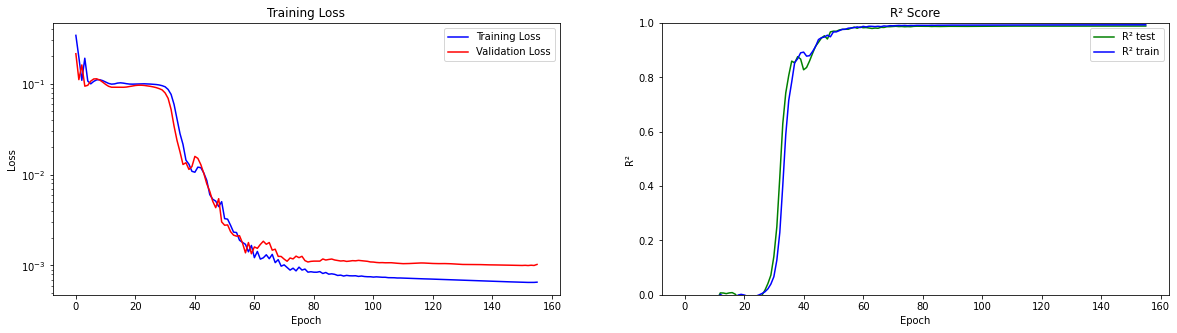

In [477]:
model, criterion, optimizer, device = make_model(input_dim=3, hidden_dim=30, output_dim=1, num_layers=10, lr=0.01)
features_train_tensor, target_train_tensor, features_test_tensor, target_test_tensor = split_data(features_normalized, target_normalized, device)
model = train_model(model, optimizer, criterion, features_train_tensor, target_train_tensor, features_test_tensor, target_test_tensor, n_epochs=300, patience=100)

In [478]:
# Passage en mode évaluation
model.eval()

with torch.no_grad():  # Assurez-vous qu'aucun gradient n'est calculé
    predictions_test = model(features_test_tensor)
    predictions_train = model(features_train_tensor)

# Calcul de l'erreur quadratique moyenne (MSE) sur l'ensemble de test
mse_test = torch.mean((predictions_test - target_test_tensor) ** 2)
print(f'MSE sur l\'ensemble de test: {mse_test.item()}')

# Calcul du R² sur l'ensemble de test
r2_test = 1 - mse_test / torch.var(target_test_tensor)
print(f'R² sur l\'ensemble de test: {r2_test.item()}')

MSE sur l'ensemble de test: 0.0010336099658161402
R² sur l'ensemble de test: 0.9887812733650208


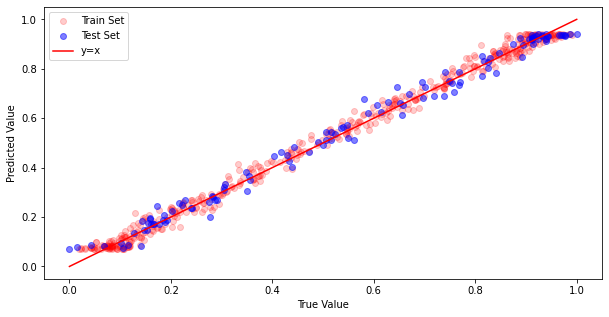

In [479]:
import matplotlib.pyplot as plt

# Conversion des prédictions et des vraies valeurs en CPU pour l'affichage
predictions_np = predictions_test.cpu().numpy()
target_np = target_test_tensor.cpu().numpy()

prediction_train_np = predictions_train.cpu().numpy()
target_train_np = target_train_tensor.cpu().numpy()

# Affichage des prédictions vs les vraies valeurs
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(target_train_np, prediction_train_np, alpha=0.2, label='Train Set', color='red')
ax.scatter(target_np, predictions_np, alpha=0.5, label='Test Set', color='blue')
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')
#add y = x line 
x = np.linspace(0, 1, 100)
y = x
ax.plot(x, y, '-r', label='y=x')
ax.legend()